# Link Percolation EBE Analysis

- Uses `analysis_utils.py` on `link_percolation/` outputs.
- Separate GC and 2-core observables.
- Includes GC vs p and |C2| vs p plots from averaged NR files.
- 2-core jump height fit uses row 26 (`core_drop`).

In [91]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import re
import analysis_utils as au

# Configure data source and mode
ROOT = Path.cwd()
DATA_DIR = ROOT / 'link_percolation'
BASE_PREFIX = 'LR'  # set to your -o prefix (without mode suffix)
MODE = 'random'    # 'adaptive', 'static', or 'random'

if MODE == 'static':
    PREFIX = f'{BASE_PREFIX}_stat'
elif MODE == 'random':
    PREFIX = f'{BASE_PREFIX}_rand'
else:
    PREFIX = BASE_PREFIX
FILE_PREFIX = f'{PREFIX}_EBE_'
NR_PREFIX = f'{PREFIX}_LR'  # averaged NR files: <prefix>_LR_ER_N...dat
STATS_PATTERN = f'stats_{FILE_PREFIX}*.dat'
OBS_GC = [('P(p+)', 4), ('P(q0)', 14)]
OBS_CORE = [('|C2|(p*)', 27)]  # p*(core) fit removed
EFFECTIVE_WINDOW = 4


In [92]:
summary = au.process_all_ebe(DATA_DIR, DATA_DIR, pattern=f"{FILE_PREFIX}*.dat", ci_radius_filter=None)
summary[['file', 'runs', 'N', 'M_graphs']]

,file,runs,N,M_graphs
0,LR_rand_EBE_LR_ER_N1024_c4.00_L0_Mg100_Mr10.dat,1000,1024,100
1,LR_rand_EBE_LR_ER_N131072_c4.00_L0_Mg100_Mr10.dat,1000,131072,100
2,LR_rand_EBE_LR_ER_N16384_c4.00_L0_Mg100_Mr10.dat,1000,16384,100
3,LR_rand_EBE_LR_ER_N2048_c4.00_L0_Mg100_Mr10.dat,1000,2048,100
4,LR_rand_EBE_LR_ER_N262144_c4.00_L0_Mg100_Mr10.dat,1000,262144,100
5,LR_rand_EBE_LR_ER_N32768_c4.00_L0_Mg100_Mr10.dat,1000,32768,100
6,LR_rand_EBE_LR_ER_N4096_c4.00_L0_Mg100_Mr10.dat,1000,4096,100
7,LR_rand_EBE_LR_ER_N65536_c4.00_L0_Mg100_Mr10.dat,1000,65536,100
8,LR_rand_EBE_LR_ER_N8192_c4.00_L0_Mg100_Mr10.dat,1000,8192,100


In [93]:
stats_files = sorted(DATA_DIR.glob(STATS_PATTERN))
stats_files[:3], len(stats_files)

([PosixPath('/nfs/nfs2/home/hanlsun/global_removal/link_percolation/stats_LR_rand_EBE_LR_ER_N1024_c4.00_L0_Mg100_Mr10.dat'),
  PosixPath('/nfs/nfs2/home/hanlsun/global_removal/link_percolation/stats_LR_rand_EBE_LR_ER_N131072_c4.00_L0_Mg100_Mr10.dat'),
  PosixPath('/nfs/nfs2/home/hanlsun/global_removal/link_percolation/stats_LR_rand_EBE_LR_ER_N16384_c4.00_L0_Mg100_Mr10.dat')],
 9)

## P (GC) and |C2| versus removed fraction p (averaged NR files)

In [94]:
nr_files = sorted(DATA_DIR.glob(f"{NR_PREFIX}_ER_*.dat"))
nr_files[:3], len(nr_files)

([PosixPath('/nfs/nfs2/home/hanlsun/global_removal/link_percolation/LR_rand_LR_ER_N1024_c4.00_L0_Mg100_Mr10.dat'),
  PosixPath('/nfs/nfs2/home/hanlsun/global_removal/link_percolation/LR_rand_LR_ER_N131072_c4.00_L0_Mg100_Mr10.dat'),
  PosixPath('/nfs/nfs2/home/hanlsun/global_removal/link_percolation/LR_rand_LR_ER_N16384_c4.00_L0_Mg100_Mr10.dat')],
 9)

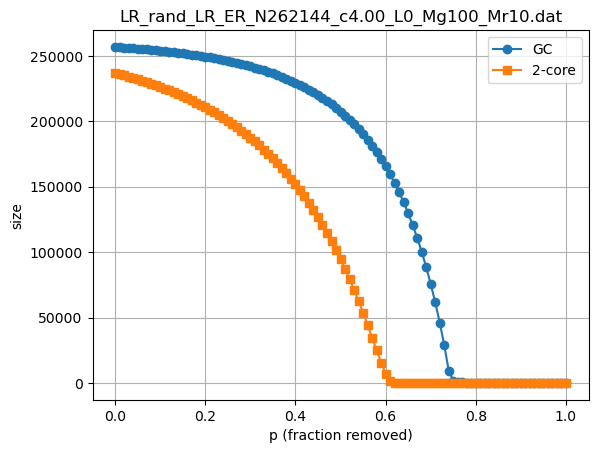

In [95]:
# Plot GC and 2-core for the largest available N
import re

def extract_N(path):
    m = re.search(r'_N(\d+)_', path.name)
    return int(m.group(1)) if m else -1

if not nr_files:
    print('No averaged NR files found.')
else:
    largest = max(nr_files, key=extract_N)
    df = au.read_nr_file(largest)
    if df.empty:
        print(f'{largest.name} is empty')
    else:
        ax = df.plot(x='p', y='P_inf', label='GC', marker='o')
        if 'core' in df.columns and df['core'].notna().any():
            df.plot(x='p', y='core', label='2-core', marker='s', ax=ax)
        ax.set_title(largest.name)
        ax.set_xlabel('p (fraction removed)')
        ax.set_ylabel('size')
        ax.grid(True)
        plt.show()


## Giant Component Observables

In [96]:
fss_gc = {}
fit_gc = {}
for label, row in OBS_GC:
    fss = au.extract_fss(stats_files, row=row, value_kind='mean')
    fss_gc[label] = fss
    fit_gc[label] = au.weighted_log_fit(fss) if not fss.empty else None
fss_gc

/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:301: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(row_data["mean"])
/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:302: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  error = float(row_data["err_mean"])


{'P(p+)':         N      value       error  \
 0    1024    279.651    3.229230   
 1    2048    469.864    5.435604   
 2    4096    754.484    8.633413   
 3    8192   1244.895   15.073084   
 4   16384   1967.490   24.415875   
 5   32768   3236.816   39.691198   
 6   65536   5071.222   63.508363   
 7  131072   8229.803  105.581030   
 8  262144  13018.800  166.630397   
 
                                               source  L  
 0  stats_LR_rand_EBE_LR_ER_N1024_c4.00_L0_Mg100_M...  0  
 1  stats_LR_rand_EBE_LR_ER_N2048_c4.00_L0_Mg100_M...  0  
 2  stats_LR_rand_EBE_LR_ER_N4096_c4.00_L0_Mg100_M...  0  
 3  stats_LR_rand_EBE_LR_ER_N8192_c4.00_L0_Mg100_M...  0  
 4  stats_LR_rand_EBE_LR_ER_N16384_c4.00_L0_Mg100_...  0  
 5  stats_LR_rand_EBE_LR_ER_N32768_c4.00_L0_Mg100_...  0  
 6  stats_LR_rand_EBE_LR_ER_N65536_c4.00_L0_Mg100_...  0  
 7  stats_LR_rand_EBE_LR_ER_N131072_c4.00_L0_Mg100...  0  
 8  stats_LR_rand_EBE_LR_ER_N262144_c4.00_L0_Mg100...  0  ,
 'P(q0)':         N     valu

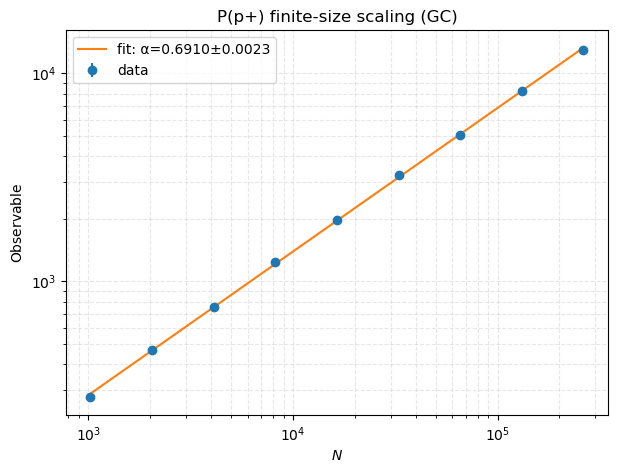

Saved plot to node_percolation/plots/fss_L0_L0_147.png


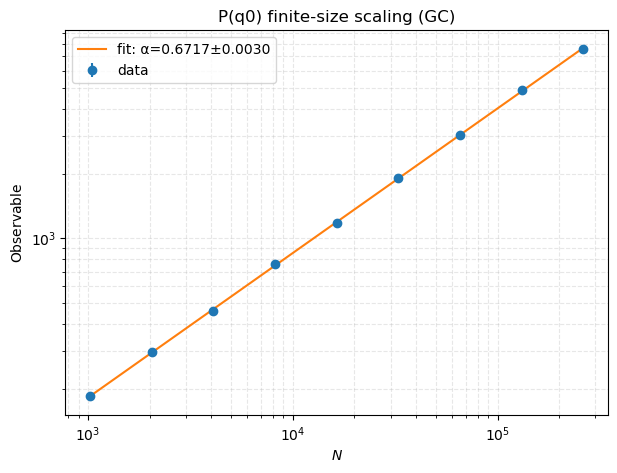

Saved plot to node_percolation/plots/fss_L0_L0_148.png


In [97]:
for label, _ in OBS_GC:
    fss = fss_gc[label]
    fit = fit_gc[label]
    if fss.empty or fit is None:
        print(f"No data for {label}")
        continue
    au.plot_fss_with_fit(fss, fit, title=f"{label} finite-size scaling (GC)")

### GC Effective Exponents

In [98]:
eff_gc = {}
for label, _ in OBS_GC:
    fss = fss_gc[label]
    if fss.empty:
        eff_gc[label] = pd.DataFrame()
    else:
        eff_gc[label] = au.compute_effective_exponents(fss, window=EFFECTIVE_WINDOW)
eff_gc

{'P(p+)':     N_left   N_right        N_geom  exponent  exponent_err
 0   1024.0    8192.0   2896.309376  0.714649      0.007607
 1   2048.0   16384.0   5792.618751  0.692331      0.007721
 2   4096.0   32768.0  11585.237503  0.696622      0.007670
 3   8192.0   65536.0  23170.475006  0.679774      0.007946
 4  16384.0  131072.0  46340.950012  0.684075      0.008127
 5  32768.0  262144.0  92681.900024  0.672101      0.008094,
 'P(q0)':     N_left   N_right        N_geom  exponent  exponent_err
 0   1024.0    8192.0   2896.309376  0.673997      0.010494
 1   2048.0   16384.0   5792.618751  0.669048      0.010209
 2   4096.0   32768.0  11585.237503  0.681292      0.010258
 3   8192.0   65536.0  23170.475006  0.666200      0.010406
 4  16384.0  131072.0  46340.950012  0.682398      0.010719
 5  32768.0  262144.0  92681.900024  0.664519      0.010463}

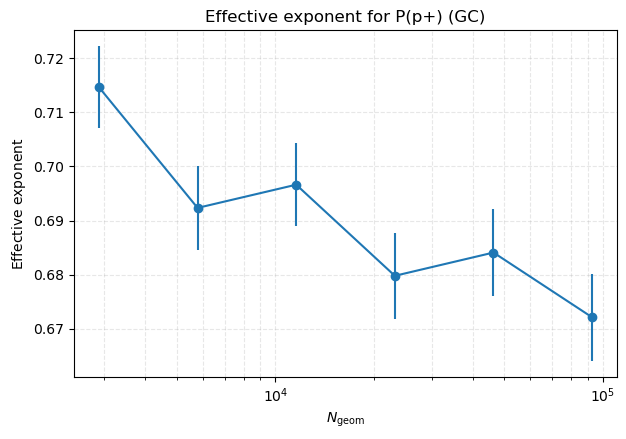

Saved plot to node_percolation/plots/eff_exp_L0_L0_117.png


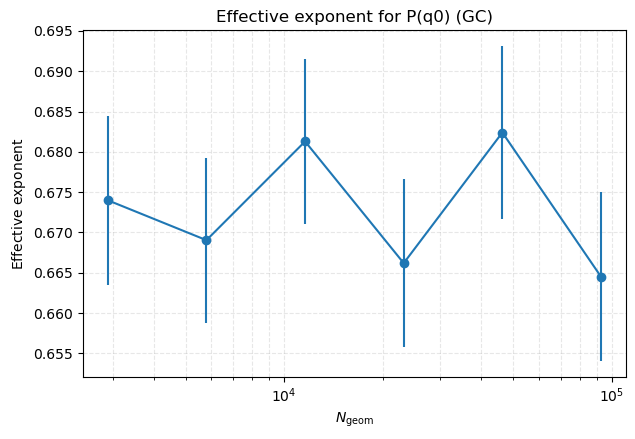

Saved plot to node_percolation/plots/eff_exp_L0_L0_118.png


In [99]:
for label, eff in eff_gc.items():
    if eff.empty:
        print(f"No effective exponents for {label}")
        continue
    au.plot_effective_exponent(eff, title=f"Effective exponent for {label} (GC)")

## 2-core Observables

In [100]:
fss_core = {}
fit_core = {}
for label, row in OBS_CORE:
    fss = au.extract_fss(stats_files, row=row, value_kind='mean')
    fss_core[label] = fss
    fit_core[label] = au.weighted_log_fit(fss) if not fss.empty else None
fss_core

/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:301: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(row_data["mean"])
/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:302: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  error = float(row_data["err_mean"])


{'|C2|(p*)':         N     value      error  \
 0    1024    48.582   1.721012   
 1    2048    81.890   2.923962   
 2    4096   124.008   4.583274   
 3    8192   167.476   6.360230   
 4   16384   269.869  10.534646   
 5   32768   383.583  15.534407   
 6   65536   575.625  23.141565   
 7  131072   819.129  33.006603   
 8  262144  1131.098  45.769398   
 
                                               source  L  
 0  stats_LR_rand_EBE_LR_ER_N1024_c4.00_L0_Mg100_M...  0  
 1  stats_LR_rand_EBE_LR_ER_N2048_c4.00_L0_Mg100_M...  0  
 2  stats_LR_rand_EBE_LR_ER_N4096_c4.00_L0_Mg100_M...  0  
 3  stats_LR_rand_EBE_LR_ER_N8192_c4.00_L0_Mg100_M...  0  
 4  stats_LR_rand_EBE_LR_ER_N16384_c4.00_L0_Mg100_...  0  
 5  stats_LR_rand_EBE_LR_ER_N32768_c4.00_L0_Mg100_...  0  
 6  stats_LR_rand_EBE_LR_ER_N65536_c4.00_L0_Mg100_...  0  
 7  stats_LR_rand_EBE_LR_ER_N131072_c4.00_L0_Mg100...  0  
 8  stats_LR_rand_EBE_LR_ER_N262144_c4.00_L0_Mg100...  0  }

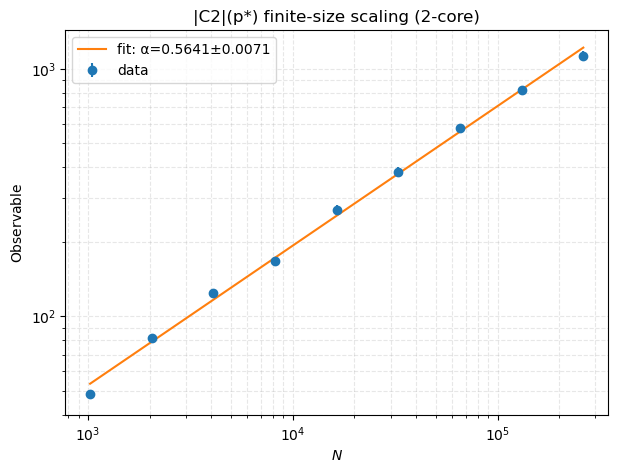

Saved plot to node_percolation/plots/fss_L0_L0_149.png


In [101]:
for label, _ in OBS_CORE:
    fss = fss_core[label]
    fit = fit_core[label]
    if fss.empty or fit is None:
        print(f"No data for {label}")
        continue
    au.plot_fss_with_fit(fss, fit, title=f"{label} finite-size scaling (2-core)")

### 2-core Effective Exponents

In [102]:
eff_core = {}
for label, _ in OBS_CORE:
    fss = fss_core[label]
    if fss.empty:
        eff_core[label] = pd.DataFrame()
    else:
        eff_core[label] = au.compute_effective_exponents(fss, window=EFFECTIVE_WINDOW)
eff_core

{'|C2|(p*)':     N_left   N_right        N_geom  exponent  exponent_err
 0   1024.0    8192.0   2896.309376  0.598318      0.023650
 1   2048.0   16384.0   5792.618751  0.558556      0.024105
 2   4096.0   32768.0  11585.237503  0.556731      0.024959
 3   8192.0   65536.0  23170.475006  0.586048      0.025262
 4  16384.0  131072.0  46340.950012  0.538943      0.025631
 5  32768.0  262144.0  92681.900024  0.518890      0.026103}

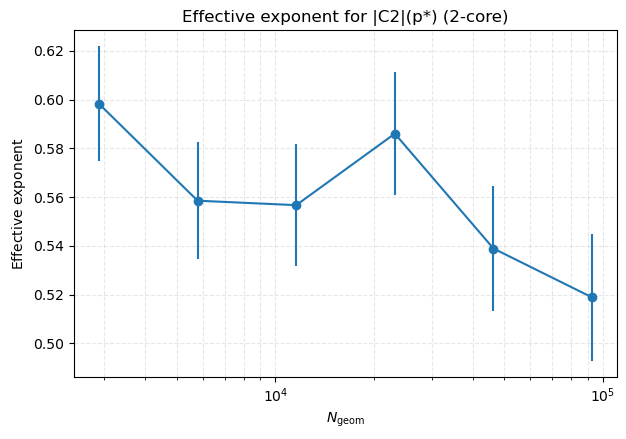

Saved plot to node_percolation/plots/eff_exp_L0_L0_119.png


In [103]:
for label, eff in eff_core.items():
    if eff.empty:
        print(f"No effective exponents for {label}")
        continue
    au.plot_effective_exponent(eff, title=f"Effective exponent for {label} (2-core)")

## 2-core Jump Height at p*

        N    value     error
0    1024   34.140  0.390357
1    2048   45.795  0.508322
2    4096   60.251  0.658487
3    8192   81.066  0.876495
4   16384  106.088  1.145639
5   32768  137.948  1.482053
6   65536  179.243  1.912850
7  131072  235.506  2.570171
8  262144  300.534  3.042190
Absolute |C2| jump-height fit: {'A': 2.3183539747438275, 'A_err': 0.04656437965864669, 'alpha': np.float64(0.3919057646597325), 'alpha_err': 0.0020169844417161076, 'chi2_red': 3.0125554957434297, 'fit_used_abs': False, 'fit_value_sign': 1.0}


/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:301: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(row_data["mean"])
/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:302: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  error = float(row_data["err_mean"])


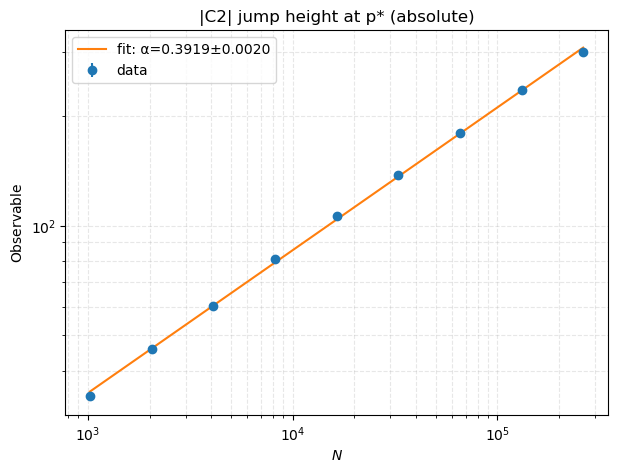

Saved plot to node_percolation/plots/fss_L0_L0_150.png


In [104]:
# Absolute jump height of |C2| at p*
core_jump_abs = au.extract_fss(stats_files, row=26, value_kind='mean')
if core_jump_abs.empty:
    print('No absolute core jump-height data found.')
else:
    core_jump_abs_fit = au.weighted_log_fit(core_jump_abs)
    print(core_jump_abs[['N', 'value', 'error']])
    print('Absolute |C2| jump-height fit:', core_jump_abs_fit)
    au.plot_fss_with_fit(core_jump_abs, core_jump_abs_fit, title='|C2| jump height at p* (absolute)')


### 2-core Jump Height Effective Exponent


    N_left   N_right        N_geom  exponent  exponent_err
0   1024.0    8192.0   2896.309376  0.413871      0.007168
1   2048.0   16384.0   5792.618751  0.406414      0.007059
2   4096.0   32768.0  11585.237503  0.397201      0.006989
3   8192.0   65536.0  23170.475006  0.381295      0.006932
4  16384.0  131072.0  46340.950012  0.382887      0.006994
5  32768.0  262144.0  92681.900024  0.376039      0.006750


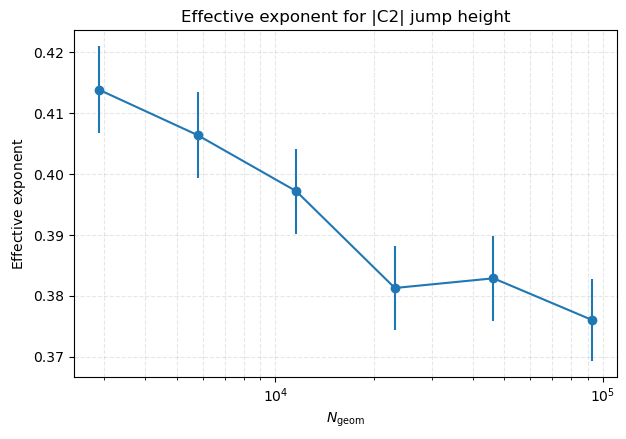

Saved plot to node_percolation/plots/eff_exp_L0_L0_120.png


In [105]:
# Effective exponent for |C2| jump height
if core_jump_abs.empty:
    print('No absolute core jump-height data for effective exponents.')
else:
    eff_core_jump = au.compute_effective_exponents(core_jump_abs, window=EFFECTIVE_WINDOW)
    print(eff_core_jump)
    au.plot_effective_exponent(eff_core_jump, title='Effective exponent for |C2| jump height')
